In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
# Define base path for all operations
BASE_PATH = os.getcwd()
BASE_PATH

'/home/gadmicha/Regression'

In [5]:
all_organelles = ["Nucleolus-(Granular-Component)", "Nuclear-envelope", "Mitochondria", "Actin-filaments",
                 "Endoplasmic-reticulum", "Plasma-membrane", "Microtubules", "DNA"]
organelle = all_organelles[1]

In [7]:
# Load errors+error_predictions
error_predictions = np.load(f"{BASE_PATH}/Variables/{organelle}_Error_Predictions_Mask_Pred.npy")
errors = np.load(f"{BASE_PATH}/Variables/{organelle}_Errors.npy")

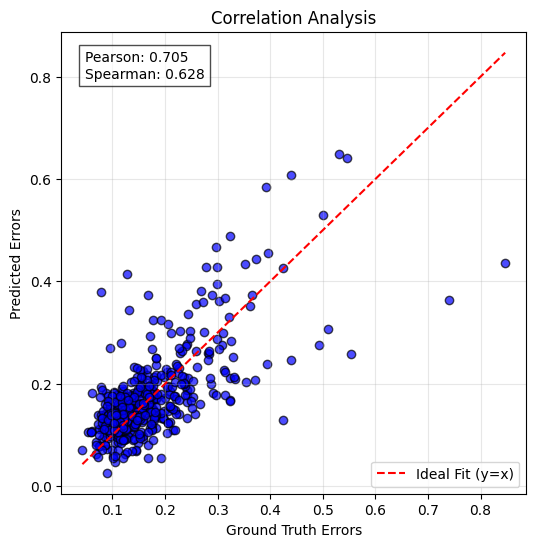

In [9]:
# Correlation
plt.figure(figsize=(6, 6))
plt.scatter(errors, error_predictions, alpha=0.7, color="blue", edgecolors='k')
plt.plot([min(errors), max(errors)], [min(errors), max(errors)], 'r--', label="Ideal Fit (y=x)")

# Correlation coefficients
pearson_corr, _ = pearsonr(errors, error_predictions)
spearman_corr, _ = spearmanr(errors, error_predictions)
plt.text(0.05, 0.9, f"Pearson: {pearson_corr:.3f}\nSpearman: {spearman_corr:.3f}",
         transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

plt.xlabel("Ground Truth Errors")
plt.ylabel("Predicted Errors")
plt.title("Correlation Analysis")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

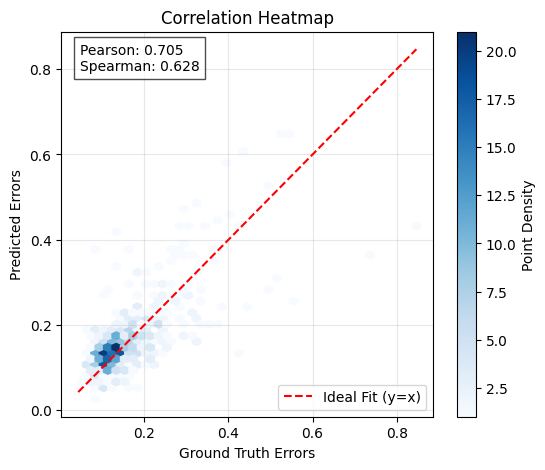

In [10]:
plt.figure(figsize=(6, 5))
hb = plt.hexbin(errors, error_predictions, gridsize=40, cmap='Blues', mincnt=1)
plt.colorbar(hb, label='Point Density')

# Add correlation text
plt.text(0.05, 0.9, f"Pearson: {pearson_corr:.3f}\nSpearman: {spearman_corr:.3f}",
         transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

plt.plot([min(errors), max(errors)], [min(errors), max(errors)], 'r--', label="Ideal Fit (y=x)")
plt.xlabel("Ground Truth Errors")
plt.ylabel("Predicted Errors")
plt.title("Correlation Heatmap")
plt.legend()
plt.grid(alpha=0.3)
# plt.savefig(f"{BASE_PATH}/Outputs/{organelle} correlation heatmap.png", bbox_inches='tight')
plt.show()


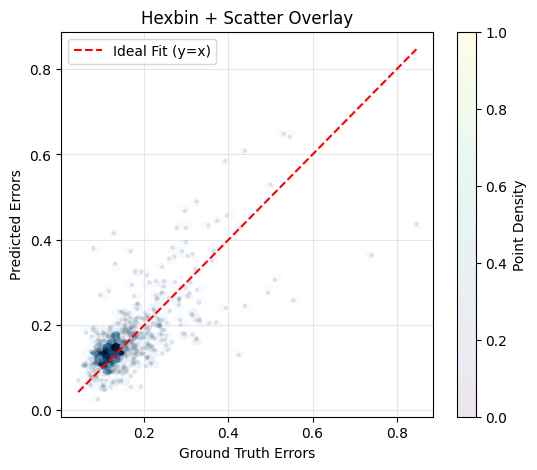

In [11]:
plt.figure(figsize=(6, 5))

# Hexbin for density
hb = plt.hexbin(errors, error_predictions, gridsize=40, cmap='Blues', mincnt=1)

# Overlay raw points with low alpha to highlight sparse areas
plt.scatter(errors, error_predictions, color='black', s=10, alpha=0.1, edgecolors='none')

# Reference line and text
plt.plot([min(errors), max(errors)], [min(errors), max(errors)], 'r--', label="Ideal Fit (y=x)")
plt.xlabel("Ground Truth Errors")
plt.ylabel("Predicted Errors")
plt.title("Hexbin + Scatter Overlay")
plt.legend()
plt.colorbar(hb, label='Point Density')
plt.grid(alpha=0.3)
# plt.savefig(f"{BASE_PATH}/Outputs/{organelle} scatter hexbin.png", bbox_inches='tight')
plt.show()


In [13]:
# Create bins
bins = []
bins_images = []
for i in range(1,11):
    bins.append([])
    j = i/10
    for k in range(len(errors)):
        if j-0.1 < errors[k] < j:
            bins[i-1].append((errors[k], error_predictions[k]))

In [14]:
gt_values = []
pred_values = []

for bin_data in bins:
    if bin_data:  # Skip empty bins
        gt, preds = zip(*bin_data)  # Separate GT and predictions
        gt_values.extend(gt)
        pred_values.extend(preds)

# Convert to numpy arrays
gt_values = np.array(gt_values)
pred_values = np.array(pred_values)

# Calculate global loss metrics
mae = np.mean(np.abs(gt_values - pred_values))  # Mean Absolute Error
mse = np.mean((gt_values - pred_values) ** 2)  # Mean Squared Error
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Print results
print(f"Global MAE: {mae:.4f}")
print(f"Global MSE: {mse:.4f}")
print(f"Global RMSE: {rmse:.4f}")

Global MAE: 0.0444
Global MSE: 0.0043
Global RMSE: 0.0659


In [16]:
# Test Predictions vs Random Labels
true_values = errors.copy()
predictions = error_predictions.copy()
n_permutations = 1000

# 1. Compute the actual performance
actual_mse = mean_squared_error(true_values, predictions)

# 2. Perform permutation test
permuted_mses = []
for _ in range(n_permutations):
    permuted_labels = np.random.permutation(true_values)
    permuted_mse = mean_squared_error(permuted_labels, predictions)
    permuted_mses.append(permuted_mse)

# 3. Compute the p-value
permuted_mses = np.array(permuted_mses)
p_value = np.mean(permuted_mses <= actual_mse)

# Print results
print(f"Actual MSE: {actual_mse}")
print(f"Permutation-based p-value: {p_value}")

Actual MSE: 0.004343799374531182
Permutation-based p-value: 0.0


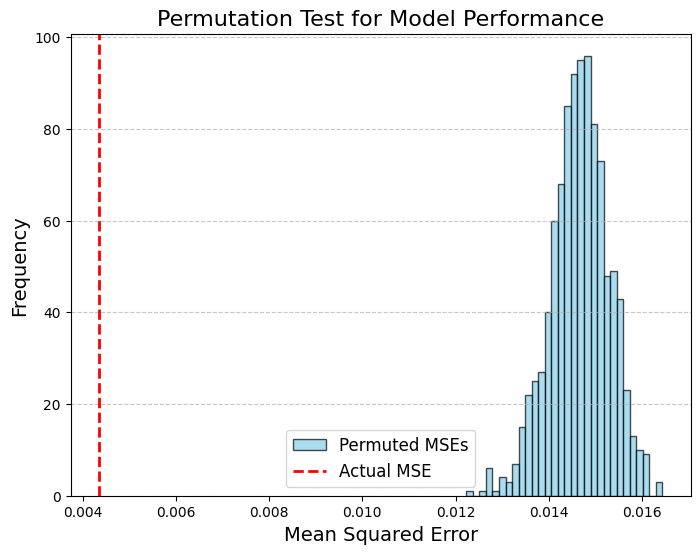

In [17]:
# Plot the histogram of permuted MSEs
plt.figure(figsize=(8, 6))
plt.hist(permuted_mses, bins=30, color='skyblue', edgecolor='black', alpha=0.7, label="Permuted MSEs")
plt.axvline(actual_mse, color='red', linestyle='--', linewidth=2, label="Actual MSE")
plt.title("Permutation Test for Model Performance", fontsize=16)
plt.xlabel("Mean Squared Error", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

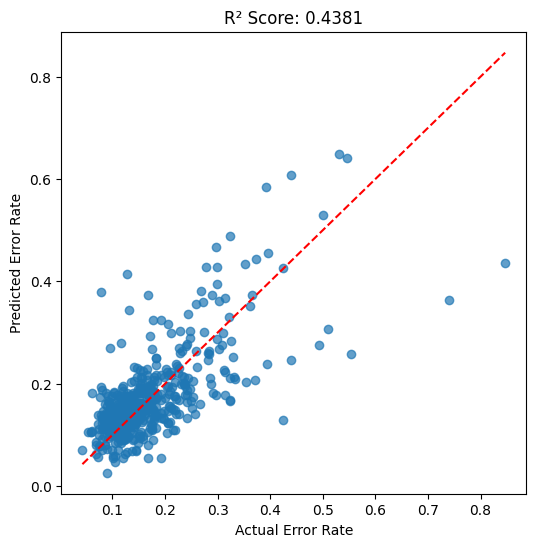

In [19]:
r2 = r2_score(errors, error_predictions)
plt.figure(figsize=(6, 6))
plt.scatter(errors, error_predictions, alpha=0.7)
plt.plot([min(errors), max(errors)], [min(errors), max(errors)], color='red', linestyle='--')
plt.xlabel("Actual Error Rate")
plt.ylabel("Predicted Error Rate")
plt.title(f"R² Score: {r2:.4f}")
plt.show()